## Module imports

In [8]:
from os import chdir
from pathlib import Path
from typing import Dict
import itertools
import warnings

# this is a bit of a hack to get relative imports
# to work as if these notebooks were in a package
# change cwd to project root if 'notebooks' in PATH
if "notebooks" in str(Path.cwd()):
    chdir("..")

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import yaml
import scipy.stats as stats
import joblib

import statsmodels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.sandbox.stats.runs import runstest_1samp
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.model_selection import GridSearchCV, train_test_split, KFold,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from src.appointments_models import MODEL_CONFIGS, baseline_scorer
import src.constants as const
from src.schemas import DataCatalog
from src.various_methods import (
    PlotCounter,
    month_num_to_cos,
    month_num_to_sin,
    get_workingdays,
)
from src.simulation_schemas import PopulationScenarios

# Importing SNEE styles
from sneeifstyles import mpl_style
mpl_style()

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Notebook Constants

In [9]:
OLD_AGE_OVER = 65
WORKING_AGE = 20
REGIONAL_APPOINTMENTS_CATALOG_NAME = "NHS GP Appointments by Region"
HISTORICAL_APPOINTMENTS_CATALOG_NAME = "NHS GP Appointments by Region, historical"
APPOINTMENTS_START_DATE = dt.date(2022, 4, 1)
NOTEBOOK_ALIAS = "num_appointments"

## Load Catalog

In [10]:
# load data catalog
catalog = DataCatalog.load_from_yaml("data_catalog.yaml")
plot_counter = PlotCounter(name=NOTEBOOK_ALIAS)

# Data loading
## Appointments SUB-ICB level

In [11]:
USED_APPOINTMENT_COLUMNS = ["SUB_ICB_LOCATION_CODE","APPOINTMENT_MONTH","HCP_TYPE","COUNT_OF_APPOINTMENTS"]

In [12]:
def load_all_areas_gp_appts(catalog_entry_name:str) ->pd.DataFrame:
    catalog_entry = catalog.get_catalog_entry_by_name(catalog_entry_name)
    _ = catalog_entry.load()

    dfs_ = []
    for ccg_name in catalog_entry.zip_file.namelist():
        catalog_entry.csv_file = ccg_name
        dfs_.append(catalog_entry.load())

    combined_df_ = pd.concat(dfs_, axis=0)

    combined_df_ = combined_df_.rename(columns={'CCG_CODE':'SUB_ICB_LOCATION_CODE',
                                                          'Appointment_Month':'APPOINTMENT_MONTH'})
    
    combined_df_ = combined_df_.loc[:,USED_APPOINTMENT_COLUMNS]
    try:
        combined_df_['APPOINTMENT_MONTH'] = pd.to_datetime(combined_df_['APPOINTMENT_MONTH'])
    except:
        combined_df_['APPOINTMENT_MONTH'] = pd.to_datetime(combined_df_['APPOINTMENT_MONTH'], format='%b-%y')
    
    return combined_df_

latest_gp_appts_df = load_all_areas_gp_appts(REGIONAL_APPOINTMENTS_CATALOG_NAME)
historical_gp_appts_df = load_all_areas_gp_appts(HISTORICAL_APPOINTMENTS_CATALOG_NAME)
historical_gp_appts_df = historical_gp_appts_df.loc[~historical_gp_appts_df['APPOINTMENT_MONTH'].isin(latest_gp_appts_df['APPOINTMENT_MONTH'].unique())]
all_area_appts_df = pd.concat([latest_gp_appts_df, historical_gp_appts_df], axis=0)

## Exploration

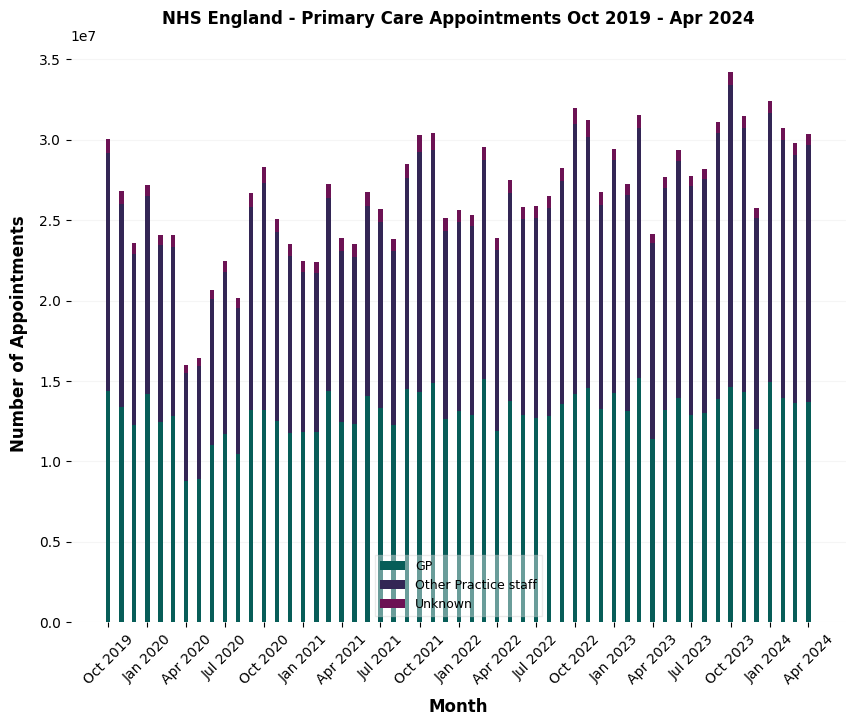

In [13]:
def stacked_bar_appointments(
    df: pd.DataFrame, title: str, ylabel: str, xlabel: str, figsize=(10, 7.5)
):
    fig, ax = plt.subplots(figsize=figsize)

    months = df["APPOINTMENT_MONTH"].unique()

    bottoms = np.zeros(len(months))
    for hcp_type in df["HCP_TYPE"].unique():
        hcp_type_slice = df[df["HCP_TYPE"] == hcp_type].copy()
        p = ax.bar(
            months,
            hcp_type_slice["COUNT_OF_APPOINTMENTS"].values,
            width=10,
            bottom=bottoms,
            label=hcp_type,
        )
        bottoms += hcp_type_slice["COUNT_OF_APPOINTMENTS"].values
    date_range = (
        str([f"{i.strftime('%b %Y')}" for i in [months.min(), months.max()]])[1:-1]
        .replace("'", "")
        .replace(",", " -")
    )
    ax.set_title(f"{title} {date_range}")
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.tick_params(axis="x", rotation=45)
    ax.legend()
    plt.savefig(f"{plot_counter.plot_name}.png")
    plt.show()


stacked_bar_appointments(
    all_area_appts_df.groupby(["APPOINTMENT_MONTH", "HCP_TYPE"])[
        ["COUNT_OF_APPOINTMENTS"]
    ]
    .sum()
    .reset_index(),
    "NHS England - Primary Care Appointments",
    "Number of Appointments",
    "Month",
)

No obvious seasonality

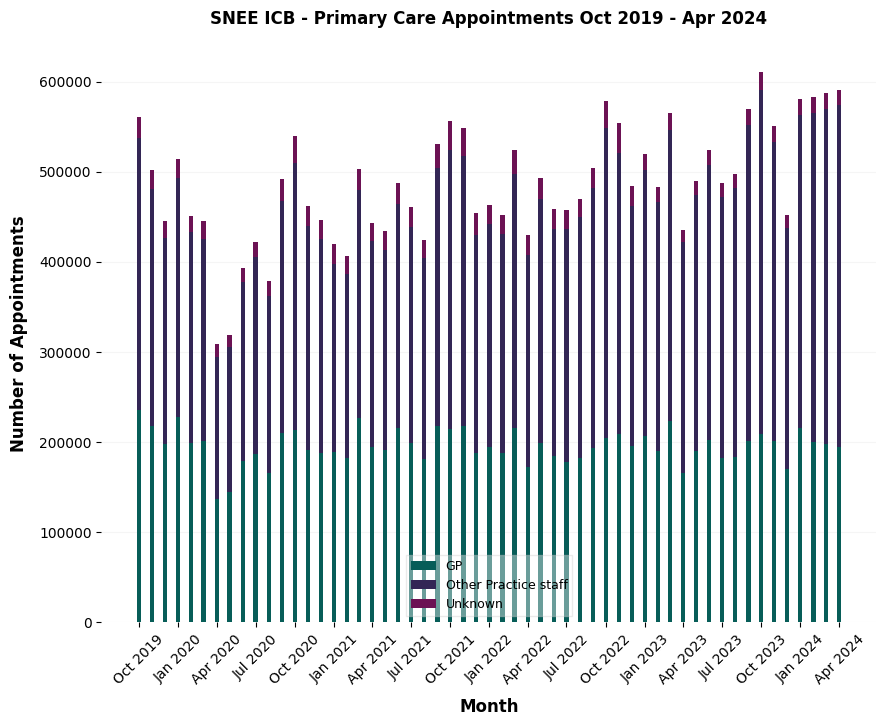

In [14]:
snee_appointments_df = (
    all_area_appts_df.loc[
        all_area_appts_df["SUB_ICB_LOCATION_CODE"].isin(
            list(const.SUB_ICB_CODES.keys())
        )
    ]
    .groupby(["APPOINTMENT_MONTH", "HCP_TYPE"])[["COUNT_OF_APPOINTMENTS"]]
    .sum()
    .reset_index()
)
stacked_bar_appointments(
    snee_appointments_df,
    "SNEE ICB - Primary Care Appointments",
    "Number of Appointments",
    "Month",
)

## EDA

In [15]:
# divide by working days/month to get average appointments per day
monthly_appts_df = snee_appointments_df.groupby('APPOINTMENT_MONTH').sum(numeric_only=True)
monthly_appts_df = monthly_appts_df.assign(WORKING_DAYS=get_workingdays(monthly_appts_df.index))
monthly_appts_df = monthly_appts_df.assign(AVG_APPTS_PER_WORKING_DAY=monthly_appts_df['COUNT_OF_APPOINTMENTS'] / monthly_appts_df['WORKING_DAYS'])
monthly_appts_df.index.freq = 'MS' # set frequency to month start

### Check stationarity - overall


In [16]:

# Assume 'data' is your time series data in a pandas Series
result = statsmodels.tsa.stattools.adfuller(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If p-value < 0.05, the data is stationary
if result[1] < 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary.")


ADF Statistic: 0.05044540726141728
p-value: 0.9625103111565132
The data is not stationary.


#### For Sub-ICBs

In [17]:
sub_icb_demand_df = all_area_appts_df.groupby(['SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH']).sum(numeric_only=True).reset_index().set_index('APPOINTMENT_MONTH')
sub_icb_demand_df = sub_icb_demand_df.assign(WORKING_DAYS=get_workingdays(sub_icb_demand_df.index))
sub_icb_demand_df = sub_icb_demand_df.assign(AVG_APPTS_PER_WORKING_DAY=sub_icb_demand_df['COUNT_OF_APPOINTMENTS'] / sub_icb_demand_df['WORKING_DAYS'])



for sub_icb in const.SUB_ICB_CODES.keys():
    # Assume 'data' is your time series data in a pandas Series
    print(f"SUB_ICB: {const.SUB_ICB_CODES[sub_icb]}")
    result =statsmodels.tsa.stattools.adfuller(sub_icb_demand_df.loc[sub_icb_demand_df['SUB_ICB_LOCATION_CODE']==sub_icb, 'AVG_APPTS_PER_WORKING_DAY'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

    # If p-value < 0.05, the data is stationary
    if result[1] < 0.05:
        print("The data is stationary.\n")
    else:
        print("The data is not stationary.\n")

SUB_ICB: Ipswich & East Suffolk
ADF Statistic: 0.4712611067351204
p-value: 0.9839729232982612
The data is not stationary.

SUB_ICB: West Suffolk
ADF Statistic: 0.6216640537701472
p-value: 0.9881376150462314
The data is not stationary.

SUB_ICB: North East Essex
ADF Statistic: -2.694164667802683
p-value: 0.07505349109951959
The data is not stationary.



### Clear seasonality

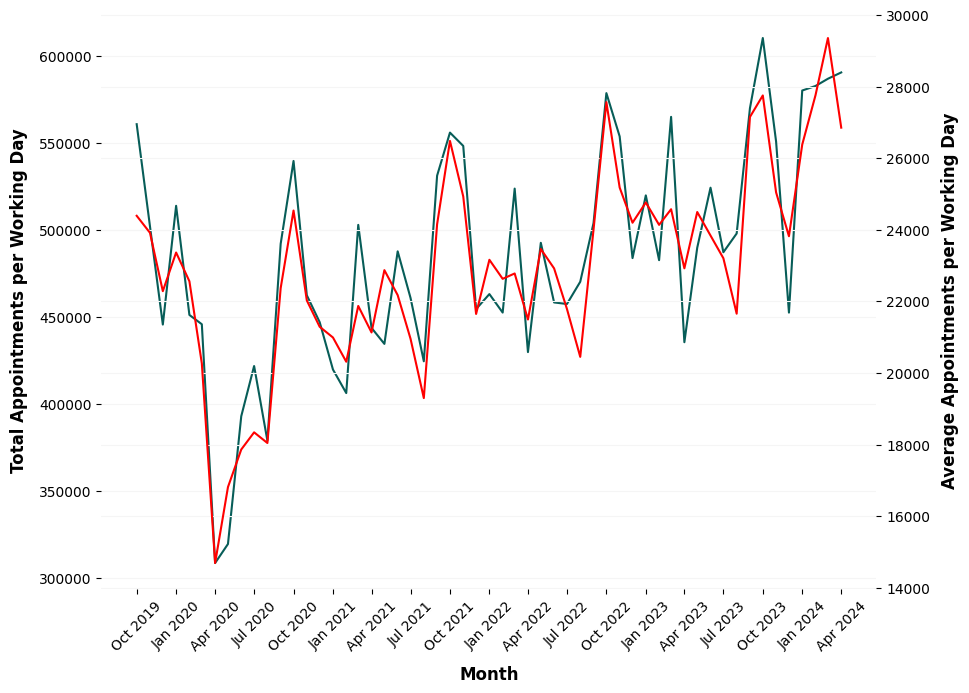

In [18]:
fig, ax = plt.subplots(figsize=(10, 7.5))
ax2 = ax.twinx()
ax.plot(monthly_appts_df['COUNT_OF_APPOINTMENTS'])
ax2.plot(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], color='r')
# y axis title
ax2.set_ylabel('Average Appointments per Working Day')
# x axis title
ax.set_ylabel('Total Appointments per Working Day')
# x axis title
ax.set_xlabel('Month')

# change x axis format to month, year
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
# rotate x axis labels
ax.tick_params(axis='x', rotation=45)
plt.show()

### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)


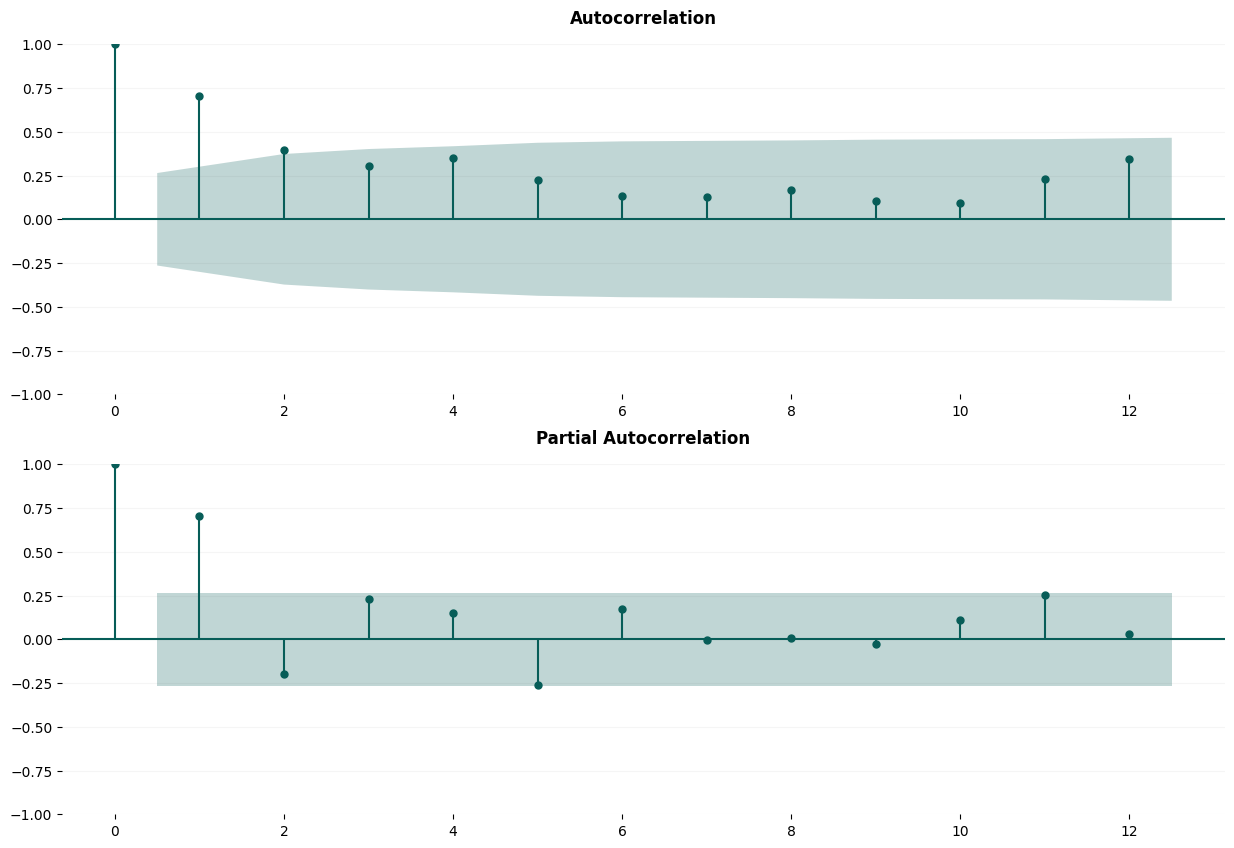

In [19]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], lags=12, ax=ax[0])
plot_pacf(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], lags=12, ax=ax[1])
plt.show()


### Decompostion

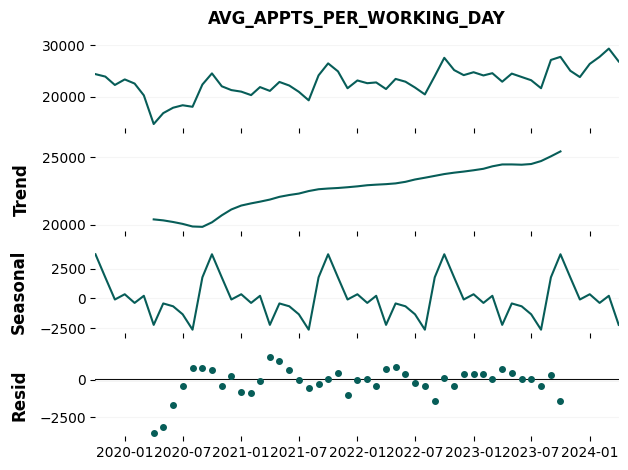

In [20]:

# Decompose the time series
result = seasonal_decompose(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], model='additive', period=12)

# Plot the decomposition
result.plot()
plt.show()


In [21]:

# Fit SARIMA model with seasonal component
model_seasonal = SARIMAX(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], order=(1,1,1), seasonal_order=(1,1,1,12))
result_seasonal = model_seasonal.fit()

# Fit ARIMA model without seasonal component
model_non_seasonal = SARIMAX(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], order=(1,1,1))
result_non_seasonal = model_non_seasonal.fit()

# Compare models
print('Seasonal AIC:', result_seasonal.aic)
print('Non-Seasonal AIC:', result_non_seasonal.aic)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.63995D+00    |proj g|=  2.29669D-01

At iterate    5    f=  6.61063D+00    |proj g|=  5.30598D-02

At iterate   10    f=  6.60966D+00    |proj g|=  5.21948D-03

At iterate   15    f=  6.60957D+00    |proj g|=  1.22430D-04

At iterate   20    f=  6.60956D+00    |proj g|=  1.84574D-03

At iterate   25    f=  6.60817D+00    |proj g|=  4.34813D-02


 This problem is unconstrained.



At iterate   30    f=  6.59426D+00    |proj g|=  8.40356D-03

At iterate   35    f=  6.59412D+00    |proj g|=  1.90448D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     39      1     0     0   1.904D-05   6.594D+00
  F =   6.5941244855998002     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.86838D+00    |proj g|=  6.19552D-02

At iterate    5    f=  8.86090D+00    |proj g|=  6.14495D-05

At iter

 This problem is unconstrained.


### 'Runs' Test

In [22]:
# Perform Runs test
runs_test_result = runstest_1samp(monthly_appts_df['AVG_APPTS_PER_WORKING_DAY'], correction=False)
print(f'Runs test statistic: {runs_test_result[0]}, p-value: {runs_test_result[1]}')


Runs test statistic: -3.129019622880717, p-value: 0.0017539059501584127


# Benchmark models - Appointments per working day

LU decomposition error. Param (0, 0, 1), error in SARIMA


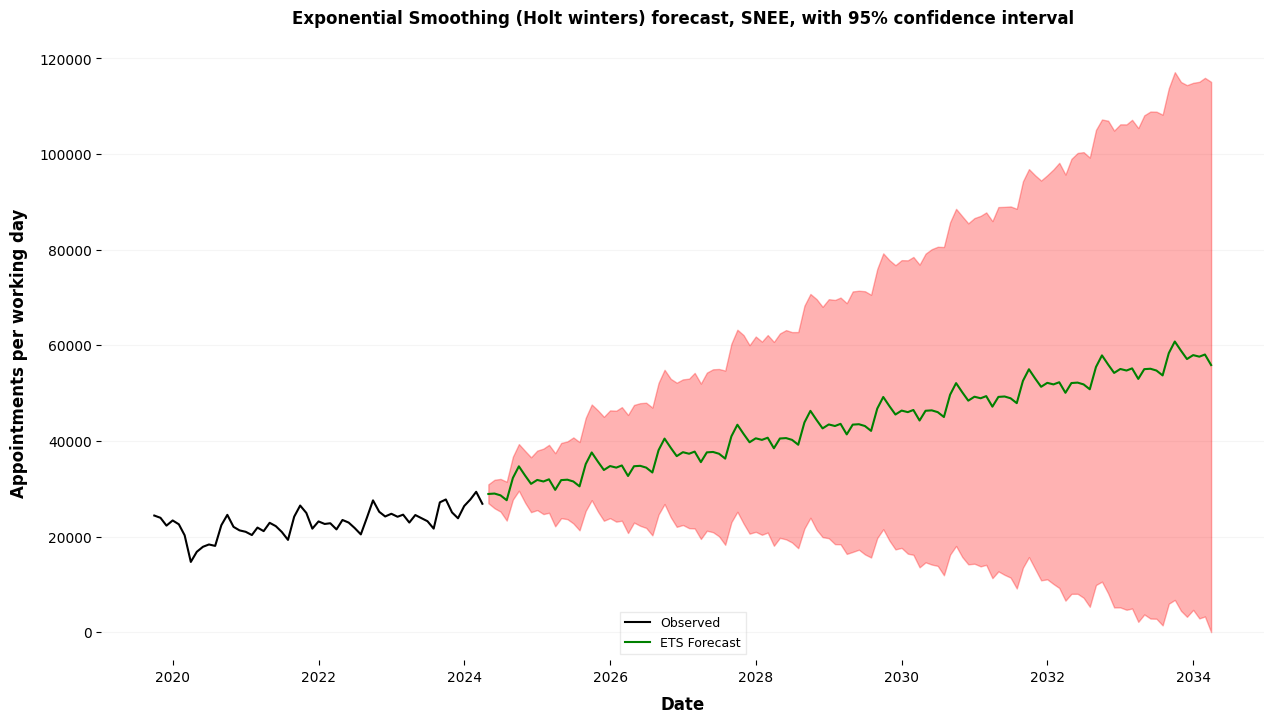

In [16]:
def forecast_seasonal(df, column, steps=12, seasonal_period=12, area='SNEE'):
    results = {}

    # Define the parameter ranges for p, d, q, P, D, Q
    p = d = q = range(0, 3)
    s = 12  # Seasonal period (e.g., monthly data with yearly seasonality)

    # Generate all different combinations of (p, d, q) and (P, D, Q) pairs
    pdq = list(itertools.product(p, d, q))
    _PDQ = [(x[0], x[1], x[2], s) for x in pdq]


    test_results = {i:{} for i in ['ARIMA','SARIMA','ETS']}
    # Initialize variables to store the best model and criteria values
    for i in test_results.keys():
        test_results[i]['best_aic'] = float("inf")
        test_results[i]['best_pdq'] = None
        best_model = None

    # iterate thorough 
    for param in pdq:
        model = 'ARIMA'
        arima_model = SARIMAX(df[column], order=param,)
        try:
            arima_fit = arima_model.fit(disp=False)
            if arima_fit.aic < test_results[model]['best_aic']:
                test_results[model]['best_aic'] = arima_fit.aic
                test_results[model]['best_pdq'] = param
                arima_forecast = arima_fit.get_forecast(steps=steps)
        except Exception as e:
            print(e, f"Param {param}, error in ARIMA")
        
        for seasonal_param in _PDQ:
            model = 'SARIMA'
            sarima_model = SARIMAX(df[column], order=param, seasonal_order=seasonal_param)
            try:
                sarima_fit = sarima_model.fit(disp=False)
                if sarima_fit.aic < test_results[model]['best_aic']:
                    test_results[model]['best_aic'] = sarima_fit.aic
                    test_results[model]['best_pdq'] = param
                    test_results[model]['best_PDQ'] = seasonal_param
                    sarima_forecast = sarima_fit.get_forecast(steps=steps)
            except Exception as e:
                print(e, f"Param {param}, error in SARIMA")


  

    # ETS
    ets_model = ExponentialSmoothing(df[column], trend='add', seasonal='add', seasonal_periods=seasonal_period)
    ets_fit = ets_model.fit()
    ets_forecast = ets_fit.forecast(steps)
    results['ETS'] = ets_forecast

    # Plotting the forecasts
    plt.figure(figsize=(15, 8))
    
    # Plot observed values
    plt.plot(df[column], label='Observed', color='black')

    # best arima params
    arima_params = str(test_results['ARIMA']['best_pdq'])[1:-1]
    # Simulate predictions.
    df_simul = ets_fit.simulate(
        nsimulations=steps,
        repetitions=1000,
        anchor='end',
    )


    # Plot ETS forecast
    plt.plot(ets_forecast.index, ets_forecast, label='ETS Forecast', color='green')
        
    # Calculate confidence intervals.
    upper_ci = df_simul.quantile(q=0.95, axis='columns')
    lower_ci = np.clip(df_simul.quantile(q=0.05, axis='columns'),0,None)



    plt.fill_between(ets_forecast.index, lower_ci, upper_ci, color='red', alpha=0.3)
   

    plt.title(f'Exponential Smoothing (Holt winters) forecast, {area}, with 95% confidence interval')
    plt.xlabel('Date')
    plt.ylabel('Appointments per working day')
    plt.legend()
    plt.show()

    return ets_forecast

# Use the function to forecast
forecast_results = forecast_seasonal(monthly_appts_df, 'AVG_APPTS_PER_WORKING_DAY', steps=120, seasonal_period=12)


### Complete for each sub-icb

In [23]:
monthly_area_appts_df = all_area_appts_df.groupby(['SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH']).sum(numeric_only=True).reset_index()
monthly_area_appts_df = monthly_area_appts_df.assign(WORKING_DAYS=get_workingdays(monthly_area_appts_df['APPOINTMENT_MONTH'].dt))
monthly_area_appts_df = monthly_area_appts_df.assign(AVG_APPTS_PER_WORKING_DAY=monthly_area_appts_df['COUNT_OF_APPOINTMENTS'] / monthly_area_appts_df['WORKING_DAYS'])

In [ ]:
forecasts = {}
for area in monthly_area_appts_df['SUB_ICB_LOCATION_CODE'].unique():
    if area in const.SUB_ICB_CODES.keys():
        area_df = monthly_area_appts_df.loc[(monthly_area_appts_df['SUB_ICB_LOCATION_CODE']==area),['APPOINTMENT_MONTH','SUB_ICB_LOCATION_CODE','AVG_APPTS_PER_WORKING_DAY']].copy().set_index('APPOINTMENT_MONTH')
        # set index frequency to monthly
        area_df.index.freq = 'MS'
        forecasts[area] = forecast_seasonal(area_df, 'AVG_APPTS_PER_WORKING_DAY', steps=132, seasonal_period=12, area='area')
    


def output_ets_forecast(forecast_results:Dict[str,pd.Series]):
    for area in forecast_results.keys():
        forecast_results[area].index = forecast_results[area].index.date
        forecast_results[area] = forecast_results[area].astype(int).to_dict()
    yaml.dump(forecast_results, open('ets_forecast_results.yaml','w'))

output_ets_forecast(forecasts)

In [ ]:
forecasts

### Multiply by population

In [25]:
monthly_area_appts_df

,SUB_ICB_LOCATION_CODE,APPOINTMENT_MONTH,COUNT_OF_APPOINTMENTS,WORKING_DAYS,AVG_APPTS_PER_WORKING_DAY
0,00L,2019-10-01,203441,23,8845.260870
1,00L,2019-11-01,177033,21,8430.142857
2,00L,2019-12-01,156654,20,7832.700000
3,00L,2020-01-01,181879,22,8267.227273
4,00L,2020-02-01,157515,20,7875.750000
...,...,...,...,...,...
5825,X2C4Y,2023-12-01,238157,19,12534.578947
5826,X2C4Y,2024-01-01,294641,22,13392.772727
5827,X2C4Y,2024-02-01,269876,21,12851.238095
5828,X2C4Y,2024-03-01,261986,20,13099.300000


In [26]:
## Multiply by population scenarios to get total appointments
pop_scenarios = {scenario.name: scenario.load() for scenario in catalog.scenario_data_sources[0].scenarios}


In [27]:
pop_scenarios['Principal projection'].loc[pop_scenarios['Principal projection']['AGE_GROUP'] == 'All ages']

,AREA_CODE,AREA_NAME,COMPONENT,SEX,AGE_GROUP,2018,2019,2020,2021,2022,...,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043
91,E38000004,NHS Barking and Dagenham CCG,Population,persons,All ages,211998.0,213423.294,214681.387,215836.155,216826.434,...,222626.633,223110.809,223618.121,224171.031,224774.823,225392.580,226012.162,226630.010,227249.839,227861.856
183,E38000005,NHS Barnet CCG,Population,persons,All ages,392140.0,395978.585,399641.401,403014.949,406061.106,...,428700.107,430291.496,431862.378,433455.467,435109.164,436755.036,438375.287,439977.126,441569.236,443146.254
275,E38000011,NHS Bexley CCG,Population,persons,All ages,247258.0,248428.446,249590.212,250759.372,251931.170,...,263924.110,264952.556,265991.059,267059.085,268179.631,269308.813,270445.395,271588.236,272739.193,273897.526
367,E38000020,NHS Brent CCG,Population,persons,All ages,330795.0,333311.812,335438.751,337289.458,338873.083,...,350379.684,351371.184,352343.136,353321.358,354293.294,355244.773,356152.099,357011.597,357831.971,358617.807
459,E38000023,NHS Bromley CCG,Population,persons,All ages,331096.0,332838.420,334612.410,336487.631,338249.835,...,353152.406,354187.087,355236.812,356347.166,357570.088,358814.014,360078.016,361367.877,362696.232,364053.536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17571,E38000045,NHS Dorset CCG,Population,persons,All ages,772268.0,775076.163,777618.744,780054.484,782436.501,...,804962.389,806096.827,807214.045,808316.047,809383.004,810506.339,811705.225,812997.200,814364.223,815791.791
17663,E38000089,NHS Kernow CCG,Population,persons,All ages,568210.0,574163.901,579793.393,585259.015,590634.370,...,643997.852,647408.469,650745.383,654016.377,657244.081,660450.583,663647.993,666835.898,670005.025,673149.256
17755,E38000129,"NHS Northern, Eastern and Western Devon",Population,persons,All ages,908806.0,915884.406,922592.524,928858.052,934899.072,...,998099.884,1002058.966,1005925.783,1009672.574,1013264.858,1016900.343,1020619.898,1024380.887,1028157.632,1031921.158
17847,E38000150,NHS Somerset CCG,Population,persons,All ages,559399.0,563570.015,567662.391,571723.903,575666.444,...,613011.482,615563.797,618103.599,620635.734,623181.167,625691.415,628153.813,630573.545,632958.487,635315.758


## load GP lists data for all areas

In [28]:
gp_list_df = catalog.get_catalog_entry_by_name(
    "Patients Registered at a GP practice, October 2023"
).load()

/workspaces/PrimaryCareDemandAndCapacity/src/schemas.py:146: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_file, **read_csv_kwargs)


## Feature Engineering

### Convert population to proportions of population

In [29]:
# keep gendered data, and age groups
def convert_gp_list_to_five_year_bins(df: pd.DataFrame) -> pd.Series:
    """
    Converts the GP list dataframe to a new dataframe with age groups grouped into five-year bins.

    Args:
        gp_list_df (pd.DataFrame): The input GP list dataframe.

    Returns:
        pd.DataFrame: The converted dataframe with age groups grouped into five-year bins.
    """

    # Filter the GP list dataframe based on specific conditions
    gp_list_df_ = df.loc[
        (df["ORG_TYPE"] == "SUB_ICB_LOCATION")
        & (df["SEX"] != "ALL")
        & (df["AGE_GROUP_5"] != "ALL")
    ].copy()

    # Select specific columns from the filtered dataframe
    gp_list_df_ = gp_list_df_.loc[:, ["ORG_CODE", "SEX", "AGE_GROUP_5", "NUMBER_OF_PATIENTS"]]

    # Modify the age group values
    gp_list_df_["AGE_GROUP_5"] = gp_list_df_["AGE_GROUP_5"].replace(
        {"90_94": "90+", "95+": "90+"}
    )
    gp_list_df_["AGE_GROUP_5"] = gp_list_df_["AGE_GROUP_5"].str.replace("_", "-")

    # Pivot table to get age group as columns
    gp_list_df_ = gp_list_df_.pivot_table(
        index="ORG_CODE", columns="AGE_GROUP_5", values="NUMBER_OF_PATIENTS", aggfunc="sum"
    )
    return gp_list_df_


def convert_5_year_gp_list_to_proportional(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts a DataFrame of 5-year GP appointment counts to proportional values.

    Args:
        df (pd.DataFrame): The input DataFrame containing 5-year GP appointment counts.

    Returns:
        pd.DataFrame: The DataFrame with the appointment counts converted to proportional values.
    """
    total_appointments = df.div(df.sum(axis=1), axis=0)
    return total_appointments


# apply the functions

gp_list_proportional_areas_df = (gp_list_df
                                 .pipe(convert_gp_list_to_five_year_bins)
                                 .pipe(convert_5_year_gp_list_to_proportional))

gp_list_5yr_bins:pd.DataFrame = gp_list_df.pipe(convert_gp_list_to_five_year_bins)
gp_list_area_totals:pd.Series = gp_list_5yr_bins.sum(axis=1)
gp_list_area_totals.name = "NUMBER_OF_PATIENTS"


In [30]:
gp_list_proportional_areas_df

AGE_GROUP_5,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,5-9,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90+
ORG_CODE,,,,,,,,,,,,,,,,,,,
00L,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,0.055354,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00N,0.046318,0.056702,0.052957,0.048391,0.058945,0.071641,0.073194,0.066699,0.056026,0.054780,0.066198,0.072568,0.070651,0.060197,0.049951,0.042973,0.025699,0.017080,0.009032
00P,0.045493,0.056224,0.055058,0.054358,0.066509,0.074500,0.071698,0.064883,0.055768,0.052966,0.067178,0.069287,0.066296,0.058151,0.049276,0.042159,0.025396,0.016355,0.008447
00Q,0.056114,0.073327,0.069254,0.062584,0.067123,0.071613,0.073718,0.071445,0.061244,0.067286,0.065642,0.061721,0.053456,0.043510,0.036411,0.030505,0.018341,0.010841,0.005862
00R,0.046429,0.056044,0.054101,0.050338,0.059426,0.070912,0.069837,0.062282,0.055081,0.054717,0.069495,0.076881,0.070049,0.057242,0.047807,0.045427,0.028257,0.017382,0.008293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D9Y0V,0.044754,0.057723,0.054875,0.056655,0.061111,0.066157,0.066390,0.064362,0.059042,0.053581,0.065510,0.069489,0.065309,0.054914,0.050100,0.049306,0.030324,0.019025,0.011373
M1J4Y,0.056761,0.067081,0.059510,0.054228,0.068206,0.077507,0.081208,0.077654,0.066476,0.064680,0.064208,0.061501,0.053169,0.042478,0.036131,0.031448,0.019132,0.012090,0.006532
M2L0M,0.044474,0.058734,0.057799,0.048705,0.055575,0.062171,0.062580,0.059900,0.056298,0.053308,0.069734,0.074576,0.069721,0.058681,0.054886,0.051284,0.032140,0.018948,0.010486


In [31]:
gp_list_5yr_bins

AGE_GROUP_5,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,5-9,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90+
ORG_CODE,,,,,,,,,,,,,,,,,,,
00L,13705,18127,17354,15141,16987,18960,19454,19388,18668,16411,23071,26075,26494,23742,21879,19933,11297,6917,3643
00N,7395,9053,8455,7726,9411,11438,11686,10649,8945,8746,10569,11586,11280,9611,7975,6861,4103,2727,1442
00P,13265,16394,16054,15850,19393,21723,20906,18919,16261,15444,19588,20203,19331,16956,14368,12293,7405,4769,2463
00Q,10347,13521,12770,11540,12377,13205,13593,13174,11293,12407,12104,11381,9857,8023,6714,5625,3382,1999,1081
00R,8291,10008,9661,8989,10612,12663,12471,11122,9836,9771,12410,13729,12509,10222,8537,8112,5046,3104,1481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D9Y0V,76886,99166,94273,97331,104985,113654,114054,110570,101431,92049,112543,119379,112197,94340,86070,84706,52096,32684,19538
M1J4Y,63334,74849,66401,60507,76104,86482,90611,86646,74173,72169,71643,68623,59326,47397,40315,35089,21347,13490,7288
M2L0M,23498,31032,30538,25733,29363,32848,33064,31648,29745,28165,36844,39402,36837,31004,28999,27096,16981,10011,5540


In [32]:
gp_list_area_totals


ORG_CODE
00L       337246
00N       159658
00P       291585
00Q       184393
00R       178574
          ...   
D9Y0V    1717952
M1J4Y    1115794
M2L0M     528348
W2U3Z    2854179
X2C4Y     457030
Name: NUMBER_OF_PATIENTS, Length: 106, dtype: int64

#### Find total appointments per sub-icb per month with the list size

In [33]:
# total appointments per sub-icb per month with the list size


all_area_appts_df = (
    all_area_appts_df.loc[
        :, ["SUB_ICB_LOCATION_CODE", "APPOINTMENT_MONTH", "COUNT_OF_APPOINTMENTS"]
    ]
    .groupby(["SUB_ICB_LOCATION_CODE", "APPOINTMENT_MONTH"])[["COUNT_OF_APPOINTMENTS"]]
    .sum()
    .reset_index()
)
all_area_appts_df = (
    all_area_appts_df.set_index("SUB_ICB_LOCATION_CODE")
    .join(gp_list_area_totals)
    .reset_index()
)

all_area_appts_df

,index,APPOINTMENT_MONTH,COUNT_OF_APPOINTMENTS,NUMBER_OF_PATIENTS
0,00L,2019-10-01,203441,337246
1,00L,2019-11-01,177033,337246
2,00L,2019-12-01,156654,337246
3,00L,2020-01-01,181879,337246
4,00L,2020-02-01,157515,337246
...,...,...,...,...
5825,X2C4Y,2023-12-01,238157,457030
5826,X2C4Y,2024-01-01,294641,457030
5827,X2C4Y,2024-02-01,269876,457030
5828,X2C4Y,2024-03-01,261986,457030


#### Number of appointments per month per person

(considers the 2023 population only)

In [34]:
# calculate appointments per person per month
all_area_appts_df = all_area_appts_df.assign(
    gp_appts_per_person=lambda df: df["COUNT_OF_APPOINTMENTS"] / df["NUMBER_OF_PATIENTS"]
).drop(columns=["COUNT_OF_APPOINTMENTS", "NUMBER_OF_PATIENTS"])
all_area_appts_df

,index,APPOINTMENT_MONTH,gp_appts_per_person
0,00L,2019-10-01,0.603242
1,00L,2019-11-01,0.524937
2,00L,2019-12-01,0.464510
3,00L,2020-01-01,0.539307
4,00L,2020-02-01,0.467063
...,...,...,...
5825,X2C4Y,2023-12-01,0.521097
5826,X2C4Y,2024-01-01,0.644686
5827,X2C4Y,2024-02-01,0.590500
5828,X2C4Y,2024-03-01,0.573236


### Add Working days/month
- Calculate appointments per working day
- drop unused columns

In [35]:
# get working days/month
all_area_appts_df["working_days"] = get_workingdays(
    all_area_appts_df["APPOINTMENT_MONTH"].dt
)
# calculate appointments per person per working day
all_area_appts_df["appts_per_person_per_workingday"] = (
    all_area_appts_df["gp_appts_per_person"] / all_area_appts_df["working_days"]
)
# get the month as a number
all_area_appts_df["month"] = all_area_appts_df["APPOINTMENT_MONTH"].dt.month
# drop columns
all_area_appts_df = all_area_appts_df.drop(
    columns=["working_days", "gp_appts_per_person", "APPOINTMENT_MONTH"]
)
all_area_appts_df

,index,appts_per_person_per_workingday,month
0,00L,0.026228,10
1,00L,0.024997,11
2,00L,0.023225,12
3,00L,0.024514,1
4,00L,0.023353,2
...,...,...,...
5825,X2C4Y,0.027426,12
5826,X2C4Y,0.029304,1
5827,X2C4Y,0.028119,2
5828,X2C4Y,0.028662,3


In [63]:
complete_dataset_df = all_area_appts_df.set_index("index").join(gp_list_proportional_areas_df)
complete_dataset_df

,appts_per_person_per_workingday,month,0-4,10-14,15-19,20-24,25-29,30-34,35-39,40-44,...,5-9,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90+
00L,0.026228,10,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00L,0.024997,11,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00L,0.023225,12,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00L,0.024514,1,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
00L,0.023353,2,0.040638,0.053750,0.051458,0.044896,0.050370,0.056220,0.057685,0.057489,...,0.048662,0.068410,0.077317,0.078560,0.070400,0.064875,0.059105,0.033498,0.020510,0.010802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X2C4Y,0.027426,12,0.050808,0.065057,0.061587,0.061451,0.069243,0.070724,0.070717,0.067488,...,0.060226,0.067737,0.065565,0.057215,0.047375,0.042236,0.038210,0.022786,0.014028,0.007402
X2C4Y,0.029304,1,0.050808,0.065057,0.061587,0.061451,0.069243,0.070724,0.070717,0.067488,...,0.060226,0.067737,0.065565,0.057215,0.047375,0.042236,0.038210,0.022786,0.014028,0.007402
X2C4Y,0.028119,2,0.050808,0.065057,0.061587,0.061451,0.069243,0.070724,0.070717,0.067488,...,0.060226,0.067737,0.065565,0.057215,0.047375,0.042236,0.038210,0.022786,0.014028,0.007402
X2C4Y,0.028662,3,0.050808,0.065057,0.061587,0.061451,0.069243,0.070724,0.070717,0.067488,...,0.060226,0.067737,0.065565,0.057215,0.047375,0.042236,0.038210,0.022786,0.014028,0.007402


## PCA

### Find the best PCA model for predicting average appointments/person

In [109]:
# Columns for PCA and month transformation
PCA_COLS = ['0-4', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44','5-9', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90+']
MONTH_COL = ['month']  # Assuming 'month' is in the dataset
TARGET__COL = 'appts_per_person_per_workingday'

# Function to perform sin/cos transformation
def sin_cos_transformer(X):
    angle = 2 * np.pi * X / 12
    sin_component = np.sin(angle)
    cos_component = np.cos(angle)
    return np.column_stack((sin_component, cos_component))

# Sin/Cos transformer using FunctionTransformer
sin_cos_transform = FunctionTransformer(sin_cos_transformer, validate=False)

# PCA transformer
pca_transformer = PCA(n_components=3)

# Preprocessing pipeline: sin/cos on month and PCA on age 
preprocessor = ColumnTransformer(
    transformers=[
        ('sin_cos', sin_cos_transform, MONTH_COL), 
        ('pca', pca_transformer, PCA_COLS)
    ],
    remainder='drop'  # Drop other columns, unless needed
)

# Train-test split
train_set = complete_dataset_df.loc[~complete_dataset_df.index.isin(const.SUB_ICB_CODES.keys())]
test_set = complete_dataset_df.loc[complete_dataset_df.index.isin(const.SUB_ICB_CODES.keys())]

# Defining features and target
X_train = train_set.drop(columns=[TARGET__COL])
y_train = train_set[TARGET__COL]

X_test = test_set.drop(columns=[TARGET__COL])
y_test = test_set[TARGET__COL]

# Fit and transform the training data
X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)

feature_names = ['month_sin', 'month_cos', 'PCA1', 'PCA2', 'PCA3']

# Changing column names
X_train_final.columns = feature_names

In [66]:
# Custom transformer to allow parameter selection for different PCA methods
class CustomPCA(BaseEstimator, TransformerMixin):
    def __init__(self, method='PCA', n_components=2, kernel='linear'):
        self.method = method
        self.n_components = n_components
        self.kernel = kernel
        self.pca_ = None

    def fit(self, X, y=None):
        if self.method == 'PCA':
            self.pca_ = PCA(n_components=self.n_components)
        elif self.method == 'KernelPCA':
            self.pca_ = KernelPCA(n_components=self.n_components, kernel=self.kernel)
        elif self.method == 'SparsePCA':
            self.pca_ = SparsePCA(n_components=self.n_components)
        self.pca_.fit(X)
        return self

    def transform(self, X):
        return self.pca_.transform(X)

    def get_params(self, deep=True):
        return {'method': self.method, 'n_components': self.n_components, 'kernel': self.kernel}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

def find_best_pca_for_forecasting(df, age_columns, target_column, n_components_range=[2, 5, 10], kernel_options=['linear', 'poly', 'rbf']):
    # Prepare the features and target variable
    X = df[age_columns]
    y = df[target_column]
    
    # Define the parameter grid
    param_grid = [
        { 'pca__method': ['PCA'], 'pca__n_components': n_components_range },
        { 'pca__method': ['KernelPCA'], 'pca__n_components': n_components_range, 'pca__kernel': kernel_options },
        { 'pca__method': ['SparsePCA'], 'pca__n_components': n_components_range },
    ]

    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', CustomPCA()),  # Custom PCA wrapper
        ('regressor', LinearRegression())
    ])

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
    grid_search.fit(X, y)
    
    # Get the best estimator
    best_pipeline = grid_search.best_estimator_
    
    # Split the data into training and test sets for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the best pipeline on the training data
    best_pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = best_pipeline.predict(X_test)
    
    # Evaluate the performance
    r2 = r2_score(y_test, y_pred)
    
    print(f'Best PCA Method: {grid_search.best_params_["pca__method"]}')
    print(f'Best PCA n_components: {grid_search.best_params_["pca__n_components"]}')
    if 'pca__kernel' in grid_search.best_params_:
        print(f'Best Kernel: {grid_search.best_params_["pca__kernel"]}')
    print(f'R² Score: {r2}')
    
    return best_pipeline


In [34]:
best_pca = find_best_pca_for_forecasting(complete_dataset_df, PCA_COLS, TARGET__COL, n_components_range=[2,3,4,5,6])

Best PCA Method: SparsePCA
Best PCA n_components: 3
R² Score: 0.18465810858723075


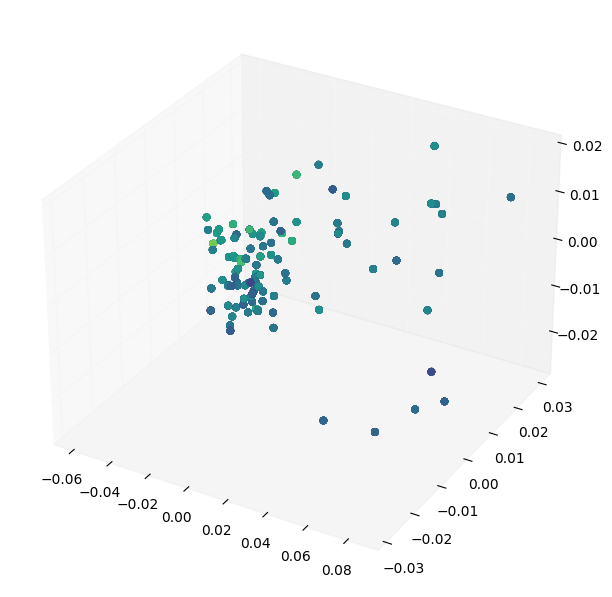

In [48]:
fig, ax = plt.subplots(figsize=(10, 7.5), subplot_kw={'projection': '3d'})
x_trans = best_pca.named_steps['pca'].transform(X_train_age_groups)
ax.scatter(X_train_final[:, 0], X_train_final[:, 1], X_train_final[:, 2], c=y_train)

plt.show()

## Running multiple models and evaluating

In [110]:
# Tune hyperparameters using GridSearchCV
def tune_hyperparameters(X_train, y_train, model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=KFold(5), scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Evaluate the model using RMSE and MAE
def calculate_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, mae

def evaluate_multiple_models(X_train, X_test, y_train, y_test):
    models = {
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [100, 300, 500],    # Number of trees in the forest; more trees can improve accuracy but increase training time.
            'max_depth': [None, 10],            # Maximum depth of the tree; deeper trees can model more complex relationships.
            'min_samples_split': [5, 10],       # Minimum number of samples required to split an internal node; controls overfitting.
        }
    },
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False],
            'copy_X': [True, False],
            'n_jobs': [None, -1, 1, 2]
        }
    },
    'Lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [0.01, 0.1, 1, 10],    # Regularization strength; higher values mean more regularization
                'fit_intercept': [True, False],
                'max_iter': [1000, 5000]        # Maximum number of iterations for convergence
            }
        },
    'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [0.01, 0.1, 1, 10],
                'fit_intercept': [True, False],
                'solver': ['auto', 'saga']      # Solver to use in the computation
            }
        },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [100, 200, 300],    # Number of boosting stages to be run; more can lead to better performance but increase computation.
            'learning_rate': [0.01, 0.1],       # Step size shrinkage; smaller values can improve performance at the cost of more trees needed.
            'max_depth': [3, 5],                # Maximum depth of the individual trees; helps prevent overfitting.
            'min_samples_split': [2, 5]         # Minimum number of samples required to split an internal node; higher values can control overfitting.
        }
    },
    'KNeighbors': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 10],
            'weights': ['uniform', 'distance'], # Number of neighbors to consider; impacts bias-variance tradeoff.
            'algorithm': ['auto', 'ball_tree'], # Weighting function; can improve accuracy by emphasizing closer neighbors.
        }
    }
    }

    results = []
    best_model = None
    best_rmse = float('inf')
    best_mae = float('inf')
    best_params = None
    
    model_dict = {}  # Dictionary to store models

    for model_name, model_info in models.items():
        print(f"Training {model_name}...")
        tuned_model, tuned_params = tune_hyperparameters(X_train, y_train, model_info['model'], model_info['params'])
        rmse, mae = calculate_metrics(tuned_model, X_test, y_test)

        results.append({
            'Model': model_name,
            'Best Params': tuned_params,
            'RMSE': rmse,
            'MAE': mae
        })
        
        # Store the trained model in model_dict
        model_dict[model_name] = tuned_model

        # Update best model based on RMSE
        if rmse < best_rmse:
            best_model = tuned_model
            best_rmse = rmse
            best_mae = mae
            best_params = tuned_params

    # Convert results to DataFrame for table-like output
    results_df = pd.DataFrame(results)

    return best_model, results_df, model_dict

In [111]:
best_model, results_df, model_dict = evaluate_multiple_models(X_train_final, X_test_final, y_train, y_test)

pd.set_option('display.max_colwidth', None)
results_df

Training RandomForest...
Training LinearRegression...
Training Lasso...
Training Ridge...
Training GradientBoosting...
Training KNeighbors...


,Model,Best Params,RMSE,MAE
0,RandomForest,"{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}",0.002556,0.002038
1,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_jobs': None}",0.002666,0.002060
2,Lasso,"{'alpha': 0.01, 'fit_intercept': True, 'max_iter': 1000}",0.003091,0.002443
3,Ridge,"{'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}",0.002667,0.002063
4,GradientBoosting,"{'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}",0.002490,0.001936
5,KNeighbors,"{'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'uniform'}",0.002607,0.002062


## Refit the model on entire Dataset then make predictions

In [133]:
# Refit the model on the entire dataset
def refit_on_full_data(X, y, model):
    model.fit(X, y)
    return model

In [134]:
# Combine X_train_final and X_test_final to create the full feature set
X_full = pd.DataFrame(np.vstack([X_train_final, X_test_final]), columns=feature_names)

# Combine y_train and y_test to create the full target set
y_full = np.concatenate([y_train, y_test])

### LR model

In [135]:
# Extract Linear Regression model
lr_model = model_dict['LinearRegression']

# Refit on all data
lr_model = refit_on_full_data(X_full, y_full, lr_model)

# Predictions on entire data
y_pred_lr = lr_model.predict(X_full)

### Gradient Boosting (Best model)

In [136]:
# Refit on all data
best_model = refit_on_full_data(X_full, y_full, best_model)

# Predictions on entire data
y_pred_best = best_model.predict(X_full)

## Evaluating LR and GB model

In [137]:
# Evaluate Gradient Boosting
rmse_gbm = root_mean_squared_error(y_full, y_pred_best)
mae_gbm = mean_absolute_error(y_full, y_pred_best)

print(f'Gradient Boosting - RMSE: {rmse_gbm:.4f}, MAE: {mae_gbm:.4f}')

# Evaluate Linear Regression
rmse_lr = root_mean_squared_error(y_full, y_pred_lr)
mae_lr = mean_absolute_error(y_full, y_pred_lr)

print(f'Linear Regression - RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}')

Gradient Boosting - RMSE: 0.0028, MAE: 0.0021
Linear Regression - RMSE: 0.0034, MAE: 0.0026


## Feature Importance

     Feature  abs_coef
2       PCA1    0.0481
3       PCA2    0.0473
4       PCA3    0.0413
1  month_cos    0.0014
0  month_sin    0.0004


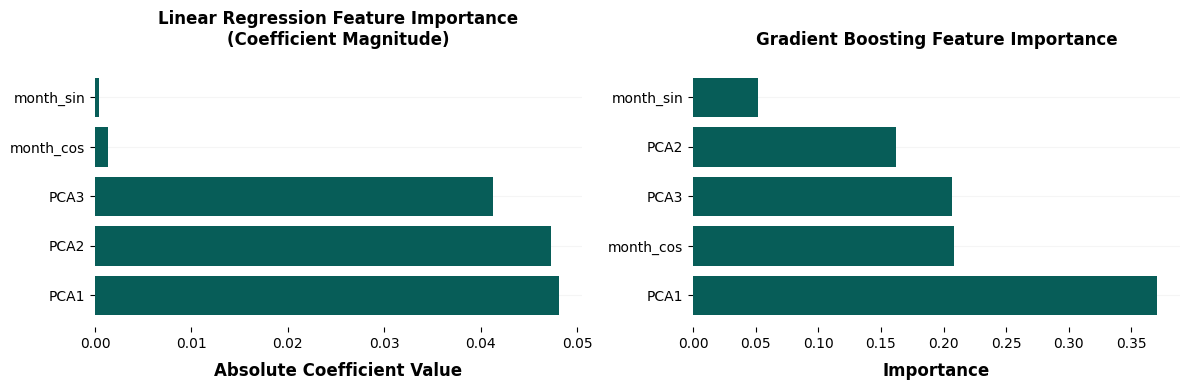

In [139]:
# Feature importance (coefficients) from LR Model
feature_importance = pd.DataFrame({
    'Feature': X_full.columns,
    'Coefficient': lr_model.coef_.round(4)
})
# Sort by absolute value of coefficients (magnitude)
feature_importance['abs_coef'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='abs_coef', ascending=False)
# Print the feature importance with magnitudes
print(feature_importance[['Feature', 'abs_coef']])


# Feature importance from Gradient Boosting Model
importance = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_full.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# First plot (Linear Regression Coefficients)
ax[0].barh(feature_importance['Feature'], feature_importance['abs_coef'])
ax[0].set_title('Linear Regression Feature Importance\n(Coefficient Magnitude)')
ax[0].set_xlabel('Absolute Coefficient Value')

# Second plot (Gradient Boosting Feature Importance)
ax[1].barh(importance_df['Feature'], importance_df['Importance'])
ax[1].set_title('Gradient Boosting Feature Importance')
ax[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

## Visualizations (only from LR Model)

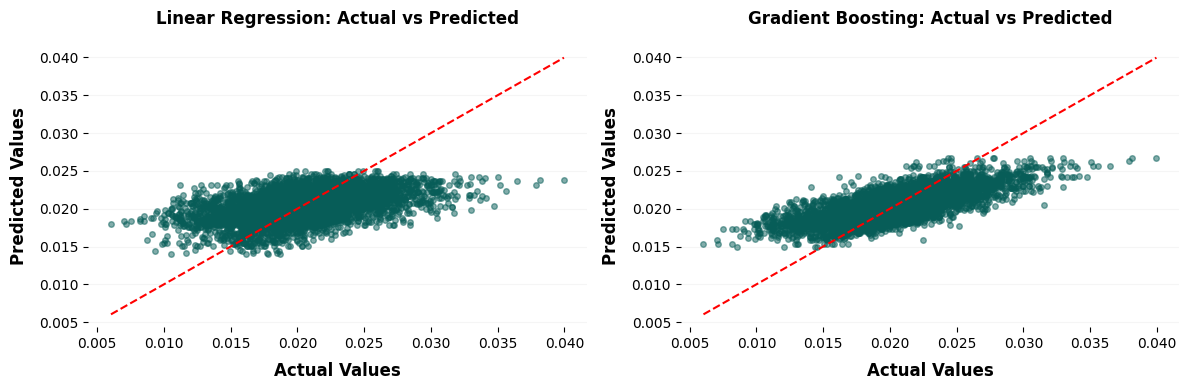

In [147]:
plt.figure(figsize=(12, 4))

# Gradient Boosting
plt.subplot(1, 2, 2)
plt.scatter(y_full, y_pred_best, alpha=0.5)
plt.plot([y_full.min(), y_full.max()], [y_full.min(), y_full.max()], color='red', linestyle='--')
plt.title('Gradient Boosting: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Linear Regression
plt.subplot(1, 2, 1)
plt.scatter(y_full, y_pred_lr, alpha=0.5)
plt.plot([y_full.min(), y_full.max()], [y_full.min(), y_full.max()], color='red', linestyle='--')
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

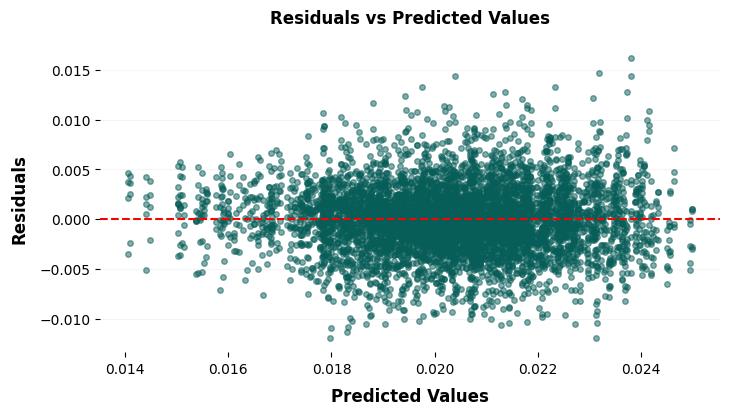

In [142]:
# Residuals
residuals = y_full - y_pred_lr

# Plot residuals vs predicted values
plt.figure(figsize=(8, 4))
plt.scatter(y_pred_lr, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

<Figure size 800x400 with 0 Axes>

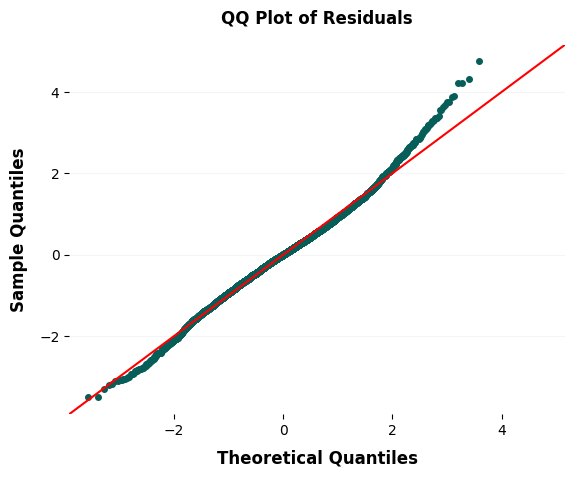

In [143]:
# QQ Plot for residuals
plt.figure(figsize=(8, 4))
sm.qqplot(residuals, line='45', fit=True)
plt.title('QQ Plot of Residuals')
plt.show()

In [144]:
# Save the final model using joblib
def save_model(model, filename):
    """
    Save the model to a file using joblib.

    Parameters:
    model : The model object to be saved.
    filename : str, the path and name of the file where the model will be saved.

    Returns:
    None
    """
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")
    

save_model(lr_model, 'outputs/lr_model.pkl')
save_model(best_model, 'outputs/gb_model.pkl')

Model saved to outputs/lr_model.pkl
Model saved to outputs/gb_model.pkl


## Test-Train Split

In [ ]:
TARGET_COL = "appts_per_person_per_workingday"

complete_dataset_df['month'].astype('category')


# remove SNEE ICBs from training set
training_dataset = complete_dataset_df.loc[
    ~complete_dataset_df.index.isin(list(const.SUB_ICB_CODES.keys()))
].copy()
test_set = complete_dataset_df.loc[
    complete_dataset_df.index.isin(list(const.SUB_ICB_CODES.keys()))
].copy()



# Split the dataset into features (X) and target variable (y)
X_train = training_dataset.copy().drop(columns=[TARGET_COL])
y_train = training_dataset[TARGET_COL]

X_test = test_set.copy().drop(columns=[TARGET_COL])
y_test = test_set[TARGET_COL]

### Baseline Model Metrics

In [ ]:
set_config(transform_output='pandas')

baseline_scores = {}
for model_config in MODEL_CONFIGS:
    # fit
    print(model_config.name, 'start, fit')
    model_config.estimator.fit(X_train, y_train)
    # predict
    print('predict')
    y_preds = model_config.estimator.predict(X_test)
    # score
    print('score')
    baseline_scores[model_config.name] = baseline_scorer(y_test, y_preds)


print('Finished')
baseline_scores_df = pd.DataFrame(baseline_scores)

basic start, fit
predict
score
poly_linear start, fit
predict
score
poly_ridge start, fit
predict
score
pca_linear start, fit
predict
score
pca_ridge start, fit
predict
score
Finished


In [ ]:
best_params = {}
tuning_results = {}
for model_config in MODEL_CONFIGS:
    # Create the GridSearchCV object
    if model_config.name =='pca_ridge':
        grid_search = RandomizedSearchCV(estimator=model_config.estimator, param_distributions=model_config.grid_search_params,
                                        cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, error_score=np.nan, n_iter=50)

        print(model_config.name, 'start: fit')
        # Fit the grid search on the training data
        grid_search.fit(X_train, y_train)

        # Get the best parameters
        best_params[model_config.name] = grid_search.best_params_

        tuning_results[model_config.name] = grid_search.cv_results_

pca_ridge start: fit
Fitting 5 folds for each of 50 candidates, totalling 250 fits


ValueError: Invalid parameter 'preprocess_scale_pca' for estimator Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['month']),
                                                 ('scale_pca',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['0-4', '5-9', '10-14',
                                                   '15-19', '20-24', '25-29',
                                                   '30-34', '35-39', '40-44',
                                                   '45-49', '50-54', '55-59',
                                                   '60-64', '65-69', '70-74',
                                                   '75-79', '80-84', '85-89',
                                                   '90+'])])),
                ('ridge', Ridge())]). Valid parameters are: ['memory', 'steps', 'verbose'].

#### One hot encoding + PCA + Polynomial Features

In [ ]:
# residuals = real - preds
# colours = test_set["month"].values
# plt.scatter(preds, residuals, c=colours, cmap='viridis')
# plt.axhline(y=0, color='r', linestyle='--')
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.title('Residual Plot')
# plt.colorbar(label='Month')
# plt.show()


In [ ]:
# colours = {'06L':1,'06T':2,'07K':3}
# plt.scatter(preds, residuals, c=test_set.index.map(colours))
# plt.axhline(y=0, color='r', linestyle='--')
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals, Appointments per person per working day')
# plt.title('Residual Plot')
# plt.colorbar(label='ICB')
# plt.show()


### Load population estimate

In [ ]:
pop_projections = PopulationScenarios.read_yaml("outputs/population_projections.yaml")
scenario_names = pop_projections.scenarios
base_scenario = pop_projections.get_scenario(scenario_names[0])
base_scenario_df = base_scenario.as_dataframe()

## Transform

In [ ]:
# use the base scenario 

In [ ]:
base_scenario_df= base_scenario_df.reset_index().assign(month = 1).set_index(['area','year','month'])

In [ ]:
def convert_population_projection_to_model_input(scenario_df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts population projection data into model input format.

    Args:
        scenario_df (pd.DataFrame): The population projection data.

    Returns:
        pd.DataFrame: The population data in model input format.
    """
    df_ = scenario_df.copy()
    # create an empty dataframe with year and month as index with all the years and months 1-12
    expanded_index_df:pd.DataFrame = pd.DataFrame(index=pd.date_range(dt.date(df_.index.get_level_values('year').min(),month=1,day=1), # jan 1st of the first year
                                                      dt.date(df_.index.get_level_values('year').max(), month=12,day=1), # dec 1st of the last year
                                                        freq='M') # month frequency
                                                        ).assign(month=lambda df: df.index.month, year=lambda df: df.index.year) # add month and year columns
    # add areas
    monthly_areas_df:pd.DataFrame = pd.concat([expanded_index_df.assign(area=area) for area in base_scenario_df.index.get_level_values('area').unique()]).set_index(['area','year','month'])
    
    # merge the two dataframes and interpolate the missing values
    monthly_population_df =  (monthly_areas_df
            .join(df_,how='outer')
            .interpolate())
    # normalise the population
    monthly_population_df = monthly_population_df.div(monthly_population_df.sum(axis=1),axis=0)
    # move month back to a column
    monthly_population_df = monthly_population_df.reset_index().set_index(['area','year'])
    # return 
    return monthly_population_df




In [ ]:
model_input_df = convert_population_projection_to_model_input(base_scenario_df)

In [ ]:
model_input_df.assign(predicted_appointments_per_person_per_workingday= lambda df:population_model.predict(df))

In [ ]:
base_scenario_df

In [ ]:
base_scenario_df.sum(axis=1) * population_model.predict(model_input_df)

In [ ]:
# # Converting 'month' to cyclic sine and cosine values (To preserve the cyclic nature)
# def convert_month_to_cyclic(df):
#     df = df.copy()
#     df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
#     df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
#     df = df.drop('month', axis=1)
#     return df

# complete_dataset_df = complete_dataset_df = convert_month_to_cyclic(complete_dataset_df)

# test_set = complete_dataset_df.loc[complete_dataset_df.index.isin(const.SUB_ICB_CODES.keys())]
# train_set = complete_dataset_df.loc[~complete_dataset_df.index.isin(const.SUB_ICB_CODES.keys())]

# PCA_COLS = ['0-4', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '5-9', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90+']
# MONTH_COLS = ['month_sin', 'month_cos']
# TARGET__COL = 'appts_per_person_per_workingday'

# # Select the relevant columns from complete_dataset_df
# X_train_age_groups = train_set[PCA_COLS]
# X_train_months = train_set[MONTH_COLS]
# y_train = train_set[TARGET__COL]

# X_test_age_groups = test_set[PCA_COLS]
# X_test_months = test_set[MONTH_COLS]
# y_test = test_set[TARGET__COL]

# # Perform PCA on the age groups
# pca = PCA(n_components=3)
# X_train_age_trans = pca.fit_transform(X_train_age_groups)
# X_test_age_trans = pca.transform(X_test_age_groups)

# # Combine the PCA-transformed age groups with the original month columns (no PCA on month features)
# X_train_final = np.hstack([X_train_age_trans, X_train_months])
# X_test_final = np.hstack([X_test_age_trans, X_test_months])

# # Train a linear regression model
# model = LinearRegression()
# model.fit(X_train_final, y_train)

# # Predict appts_per_person_per_workingday using the PCA of age groups
# y_pred = model.predict((X_test_final))